In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In Data_Transformation we always do EDA and Feature engineering on Train Data from now on we only focus on train data we never see test data until our model is ready

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df.shape

(22324, 30)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22324 entries, 0 to 22323
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   finishing_position     22324 non-null  object 
 1   horse_number           22313 non-null  float64
 2   horse_name             22324 non-null  object 
 3   horse_id               22324 non-null  object 
 4   jockey                 22324 non-null  object 
 5   trainer                22324 non-null  object 
 6   actual_weight          22324 non-null  int64  
 7   declared_horse_weight  22324 non-null  object 
 8   draw                   22324 non-null  object 
 9   length_behind_winner   20426 non-null  object 
 10  running_position_1     22306 non-null  float64
 11  running_position_2     22306 non-null  float64
 12  running_position_3     22306 non-null  float64
 13  running_position_4     12267 non-null  float64
 14  finish_time            22324 non-null  object 
 15  wi

Analysis

Use panda profiling for EDA

In [5]:


# Assuming `df` is your pandas DataFrame
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("Analysis_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print("Number of Horses", df.horse_name.nunique())
print("Number of Horses_id", df.horse_id.nunique())
print("Number of jockeys", df.jockey.nunique())
print("Number of trainer", df.trainer.nunique())

Number of Horses 2156
Number of Horses_id 2156
Number of jockeys 105
Number of trainer 95


In [8]:
df = df[df['finishing_position'].isin([str(i) for i in range(1, 13)])].reset_index(drop=True)

In [9]:
df.finishing_position.unique()

array(['3', '12', '7', '10', '9', '8', '2', '1', '5', '11', '4', '6'],
      dtype=object)

open Analysis_report.html

Feature Engineering

In [10]:
def recent_rank(data):
    # Add a column named recent_6_runs to the dataframe, which records the recent ranks of the horse in each entry.
# The ranks are separated by “/”, and a record is like 1/2/6/3/4/7.    This column concatenates the last 6 (or fewer) finishing positions of the horse for each row, separated by /.

# Add a column named recent_ave_rank for each entry to the dataframe,
# This column calculates the average of the recent finishing positions (up to the last 6 races) for each horse.

    df['recent_6_runs'] = '0'
    df['recent_ave_rank'] = np.nan

    for i in range(len(df['finishing_position'])):

        # temp will just give a list of all the finishing positions of that particular horse
        temp = df[ : (i + 1)][df.horse_id == df.horse_id[i]][['finishing_position']]

        # we convert temp into a list, in reverse order, with the last race in front
        temp = temp['finishing_position'].values.tolist()[::-1]

        # we then take the first 6 elements of the list, and join them with a '/'
        df['recent_6_runs'][i] = '/'.join(temp[:6])

        # if list is not empty, then we convert string to float and take the average to get the recent_ave_rank
        if len(temp) != 0:
            temp_int = map(int,temp)
            temp_ave = np.mean(list(temp_int))
            df['recent_ave_rank'][i] = temp_ave
recent_rank(df)

In [11]:
df.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'src',
       'race_date', 'race_course', 'race_number', 'race_class',
       'race_distance', 'track_condition', 'race_name', 'track',
       'sectional_time', 'incident_report', 'recent_6_runs',
       'recent_ave_rank'],
      dtype='object')

Now working on categorical data

In [12]:
# Convert 'race_date' to datetime
df['race_date'] = pd.to_datetime(df['race_date'])

In [13]:
df['declared_horse_weight'] = df['declared_horse_weight'].astype(int)

In [14]:
#create new column season with the help of race date so we can find out on which season which horse do well. We have 4 seasons in asia.
def determine_hk_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # [9, 10, 11]
        return 'Autumn'

df['Season'] = df['race_date'].apply(determine_hk_season)

In [15]:
df.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'src',
       'race_date', 'race_course', 'race_number', 'race_class',
       'race_distance', 'track_condition', 'race_name', 'track',
       'sectional_time', 'incident_report', 'recent_6_runs', 'recent_ave_rank',
       'Season'],
      dtype='object')

In [16]:
# jockey_ave_rank: records the average rank of the jockey
# trainer_ave_rank: records the average rank of the trainer

def cal_ave_rank(data):
    df['jockey_ave_rank'] = '0'
    jockeys = df['jockey'].unique()
    for i in range(len(jockeys)):
        temp = df[df.jockey == jockeys[i]][['finishing_position']]
        temp = temp['finishing_position'].values.tolist()
        if len(temp) != 0:
            temp_int = map(int, temp)
            temp_ave = np.mean(list(temp_int))
            df['jockey_ave_rank'][df.jockey == jockeys[i]] = temp_ave


    df['trainer_ave_rank'] = '0'
    trainers = df['trainer'].unique()
    for i in range(len(trainers)):
        temp = df[df.trainer == trainers[i]][['finishing_position']]
        temp = temp['finishing_position'].values.tolist()
        if len(temp) != 0:
            temp_int = map(int,temp)
            temp_ave = np.mean(list(temp_int))
            df['trainer_ave_rank'][df.trainer == trainers[i]] = temp_ave
cal_ave_rank(df)

In [17]:
df.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'src',
       'race_date', 'race_course', 'race_number', 'race_class',
       'race_distance', 'track_condition', 'race_name', 'track',
       'sectional_time', 'incident_report', 'recent_6_runs', 'recent_ave_rank',
       'Season', 'jockey_ave_rank', 'trainer_ave_rank'],
      dtype='object')

Working on more categorical data

In [19]:
def map_columns(data):
    """
    Maps categorical columns in a DataFrame to unique numeric IDs based on predefined mappings.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns to map.

    Returns:
    pd.DataFrame: A DataFrame with additional columns for mapped IDs.
    """
    # Define the mappings
    race_course_mapping = {
        'Sha Tin': 0,
        'Happy Valley': 1
    }

    track_mapping = {
        'TURF - "A" COURSE': 1,
        'TURF - "C" COURSE': 2,
        'TURF - "C+3" COURSE': 3,
        'TURF - "B" COURSE': 4,
        'ALL WEATHER TRACK': 5,
        'TURF - "B+2" COURSE': 6,
        'TURF - "A+3" COURSE': 7
    }

    season_mapping = {
        'Spring': 1,
        'Winter': 2,
        'Autumn': 3,
        'Summer': 4
    }

    track_condition_mapping = {
    'GOOD': 1,
    'GOOD TO FIRM': 2,
    'GOOD TO YIELDING': 3,
    'YIELDING': 4,
    'WET SLOW': 5,
    'FAST': 6,
    'WET FAST': 7,
    'YIELDING TO SOFT': 8,
    'SOFT': 9
    }

    # Apply the mappings
    df['race_course_id'] = df['race_course'].map(race_course_mapping)
    df['track_id'] = df['track'].map(track_mapping)
    df['season_id'] = df['Season'].map(season_mapping)
    df['track_condition_id'] = df['track_condition'].map(track_condition_mapping)

map_columns(df)


In [20]:
df.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'src',
       'race_date', 'race_course', 'race_number', 'race_class',
       'race_distance', 'track_condition', 'race_name', 'track',
       'sectional_time', 'incident_report', 'recent_6_runs', 'recent_ave_rank',
       'Season', 'jockey_ave_rank', 'trainer_ave_rank', 'race_course_id',
       'track_id', 'season_id', 'track_condition_id'],
      dtype='object')

In [21]:
df.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,incident_report,recent_6_runs,recent_ave_rank,Season,jockey_ave_rank,trainer_ave_rank,race_course_id,track_id,season_id,track_condition_id
0,3,12.0,CAREFREE LET GO,T059,M L Yeung,C S Shum,112,1060,2,2,...,\n After beginning awkwardly an...,3,3.0,Autumn,6.978346,6.160865,0,7,3,1
1,3,1.0,VERY RICH MAN,V286,U Rispoli,T K Ng,133,1057,9,3/4,...,\n KWAICHUNG BROTHERS was slow ...,3,3.0,Winter,6.046036,7.483495,1,3,2,2
2,12,4.0,FANTASTIC KAKA,P363,B Prebble,L Ho,125,1125,1,7-1/4,...,\n PHOTON WILLIE was crowded fo...,12,12.0,Winter,5.819498,6.628495,0,1,2,1
3,7,6.0,VICTORY MAGIC,T272,J Moreira,J Moore,122,1154,1,3-1/2,...,\n DEEP THINKER was checked whe...,7,7.0,Spring,4.04498,5.861614,0,3,1,4
4,10,4.0,EXCITING DREAM,P191,H Bowman,J Moore,127,1079,1,4-3/4,...,\n DIVINE CALLING was withdrawn...,10,10.0,Winter,5.316456,5.861614,0,1,2,1


In [22]:
# Assuming `df` is your pandas DataFrame
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("Analysis_report_all.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22236 entries, 0 to 22235
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   finishing_position     22236 non-null  object        
 1   horse_number           22236 non-null  float64       
 2   horse_name             22236 non-null  object        
 3   horse_id               22236 non-null  object        
 4   jockey                 22236 non-null  object        
 5   trainer                22236 non-null  object        
 6   actual_weight          22236 non-null  int64         
 7   declared_horse_weight  22236 non-null  int64         
 8   draw                   22236 non-null  object        
 9   length_behind_winner   20338 non-null  object        
 10  running_position_1     22236 non-null  float64       
 11  running_position_2     22236 non-null  float64       
 12  running_position_3     22236 non-null  float64       
 13  r

In [24]:
df.to_csv('./data/new_train.csv', index=False)

Advance_EDA

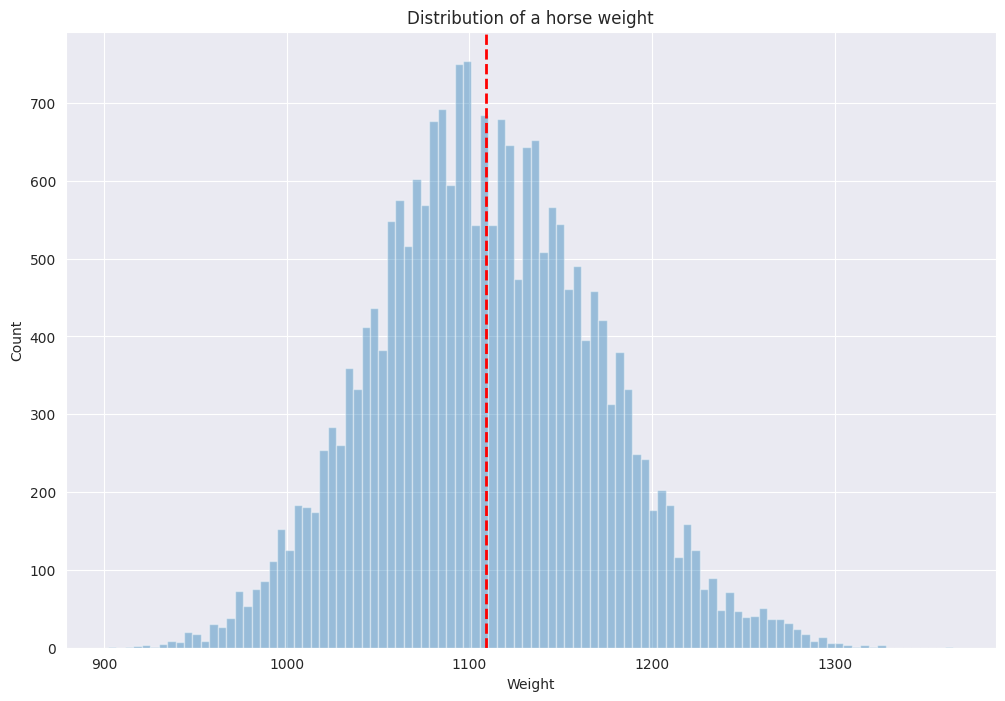

In [25]:
# Draw the mean of a horse weight on same plot
# Draw the mean of a horse weight on same plot
plt.figure(figsize=(12, 8))
sns.distplot(df['declared_horse_weight'], bins=100, kde=False)
plt.title("Distribution of a horse weight")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.axvline(df['declared_horse_weight'].mean(), color='r', linestyle='dashed', linewidth=2)

plt.show()